In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../..'))) # access sibling directories

from src.python.models import MainSimulator

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

# Model formulation

We define stimulus type and response as
- 0 = "new"
- 1 = "old".

## Signal-detection model

Hyperpriors:
$$
\begin{align}
\mu_{h'} &\sim \mathcal{N}(0.5, 1) \\
\sigma_{h'} &\sim \textrm{Gamma}(1, 1)\\
\mu_{f'} &\sim \mathcal{N}(-1, 1)\\
\sigma_{f'} &\sim \textrm{Gamma}(1, 1)\\
\end{align}
$$
Group-level model:
$$
\begin{align}
h_m' &\sim \mathcal{N}(\mu_{h'}, \sigma_{h'}) \text{ for } m=1,\dots,M\\
f_m' &\sim \mathcal{N}(\mu_{f'}, \sigma_{f'}) \text{ for } m=1,\dots,M\\
h_m &= \Phi(h_m') \text{ for } m=1,\dots,M\\
f_m &= \Phi(f_m') \text{ for } m=1,\dots,M\\
\end{align}
$$
Observation-level model:
$$
\begin{align}
x_n^{h}|h_m &\sim \textrm{Bin}(O_m, h_m) \text{ for } n=1,\dots,N_m\\
x_n^{f}|f_m &\sim \textrm{Bin}(W_m, f_m) \text{ for } n=1,\dots,N_m
\end{align}
$$

$\Phi =$ Standard normal cumulative distribution function

$h_m' = \Phi^{-1}(h_m) =$ probit-transformed hit probability (on old items)

$f_m' = \Phi^{-1}(f_m) =$ probit-transformed false alarm probability (on new items)

$O_m =$ Number of old/signal trials per participant m

$W_m =$ Number of new/noise trials per participant m

[Notation follows Rouder & Lu (2005)]

[Priors are loosely informed by the results of Greene, Martin & Naveh-Benjamin (2021)]

## MPT model (latent-trait 2HTM)

Hyperpriors:
$$
\begin{align}
\mu_{d'} &\sim \mathcal{N}(0, 1) \\
\mu_{g'} &\sim \mathcal{N}(0, 1) \\
\lambda_p &\sim \textrm{Uniform}(0, 10) \text{ for } p= d', g'\\
Q &\sim InvWishart(\mathbb{I}, P+1)\\
\Sigma &= \textrm{Diag}(\lambda_p) Q \textrm{Diag}(\lambda_p)\\
\end{align}
$$
Group-level model:
$$
\begin{align}
\left[ \begin{array}{l} d_m' \\ g_m' \end{array} \right] 
&\sim \mathcal{N} \left( 
\left[\begin{array}{l} \mu_{d'} \\ \mu_{g'} \end{array} \right], \Sigma
\right) \text{ for } m=1,\dots,M\\

d_m &= \Phi(d_m') \text{ for } m=1,\dots,M\\
g_m &= \Phi(g_m') \text{ for } m=1,\dots,M\\
h_m &= d_m + (1-d_m)*g_m \text{ for } m=1,\dots,M\\
f_m &= (1-d_m)*g_m \text{ for } m=1,\dots,M\\
\end{align}
$$
Observation-level model:
$$
\begin{align}
x_n^{h}|h_m &\sim \textrm{Bin}(O_m, h_m) \text{ for } n=1,\dots,N_m\\
x_n^{f}|f_m &\sim \textrm{Bin}(W_m, f_m) \text{ for } n=1,\dots,N_m
\end{align}
$$

Restriction: $d_O = d_W$

$\Phi =$ Standard normal cumulative distribution function

$h_m' = \Phi^{-1}(h_m) =$ probit-transformed hit probability (on old items)

$f_m' = \Phi^{-1}(f_m) =$ probit-transformed false alarm probability (on new items)

$O_m =$ Number of old/signal trials per participant m

$W_m =$ Number of new/noise trials per participant m

[Notation follows Klauer (2010)]

[Prior choices are informed by Gronau, Wagenmakers & Heck (2019)]

# Simulator

In [4]:
class HierarchicalSdtMptSimulator:

    def __init__(self):
        pass

    def draw_from_prior(self, model_index, n_clusters):
        """ Draws parameter values from the specified prior distributions of the hyperprior and the conditional prior.
            Also computes hit and false alarm probabilities for each participant (to be compatible with the MainSimulator class).

        Parameters
        ----------
        model_index : int
            Index of the model to be simulated from.
        n_clusters : int
            Number of higher order clusters that the observations are nested in.

        Returns
        -------
        p_h_m : np.array
            Hit probability per cluster.
        p_h_m : np.array
            False alarm probability per cluster.
        """

        RNG = np.random.default_rng()
        
        if model_index == 0: # SDT model

            # Hyperpriors
            mu_h = RNG.normal(0.5, 1)
            sigma_h = RNG.gamma(1, 1)
            mu_f = RNG.normal(-1, 1)
            sigma_f = RNG.gamma(1, 1)

            # Group-level priors
            h_m = RNG.normal(loc=mu_h, scale=sigma_h, size=n_clusters)
            f_m = RNG.normal(loc=mu_f, scale=sigma_f, size=n_clusters)

            # Transform probit-transformed parameters to probabilities
            p_h_m = stats.norm.cdf(h_m) 
            p_f_m = stats.norm.cdf(f_m)

        if model_index == 1: # MPT model

            # Hyperpriors
            mu_d = RNG.normal(0, 1)
            mu_g = RNG.normal(0, 1)
            lambdas = RNG.uniform(0, 10, size=2)
            Q = stats.invwishart.rvs(df=3, scale=np.identity(2))
            sigma = np.matmul(np.matmul(np.diag(lambdas), Q), np.diag(lambdas))

            # Group-level priors
            params = RNG.multivariate_normal([mu_d, mu_g], sigma, size=n_clusters)
            d_m = params[:, 0]
            g_m = params[:, 1]
            p_d_m = stats.norm.cdf(d_m) # Transform probit-transformed parameters to probabilities
            p_g_m = stats.norm.cdf(g_m) # Transform probit-transformed parameters to probabilities
            p_h_m = p_d_m + (1-p_d_m)*p_g_m
            p_f_m = (1-p_d_m)*p_g_m
        
        return p_h_m, p_f_m

    def generate_from_likelihood(self, p_h_m, p_f_m, n_clusters, n_obs):
        """ Generates a single hierarchical data set from the sampled parameter values.

        Parameters
        ----------
        p_h_m : np.array
            Hit probability per cluster.
        p_h_m : np.array
            False alarm probability per cluster.
        n_clusters : int
            Number of higher order clusters that the observations are nested in.
        n_obs : int
            Number of observations per cluster.

        Returns
        -------
        X : np.array
            Generated data set with shape (n_clusters, n_obs, 2).
            Contains 2 binary variables with stimulus type and response (for both applies: 0="new" / 1="old").
        """
        
        RNG = np.random.default_rng()

        # Determine amount of signal (old item) and noise (new item) trials
        assert n_obs%2 == 0, "n_obs has to be dividable by 2."
        n_trials_per_cat = int(n_obs/2)

        # Create stimulus types (0="new" / 1="old")
        stim_cluster = np.repeat([[1,0]], repeats=n_trials_per_cat, axis=1) # For 1 participant
        stim_data_set = np.repeat(stim_cluster, repeats=n_clusters, axis=0) # For 1 data set

        # Create individual responses (0="new" / 1="old")
        X_h = RNG.binomial(n=1, p=p_h_m, size=(n_trials_per_cat, n_clusters)).T # Old items
        X_f = RNG.binomial(n=1, p=p_f_m, size=(n_trials_per_cat, n_clusters)).T # New items
        X_responses = np.concatenate((X_h, X_f), axis=1)

        # Create final data set
        X = np.stack((stim_data_set, X_responses), axis=2)

        return X

    def generate_single(self, model_index, n_clusters, n_obs):
        """Generates a single hierarchical data set utilizing the draw_from_prior and gen_from_likelihood functions.

        Parameters
        ----------
        model_index : int
            Index of the model to be simulated from.
        n_clusters : int
            Number of higher order clusters that the observations are nested in.
        n_obs : int
            Number of observations per cluster.

        Returns
        -------
        X : np.array
            Generated data set with shape (n_clusters, n_obs, 2).
            Contains 2 binary variables with stimulus type and response (for both applies: 0="new" / 1="old").
        """

        p_h_m, p_f_m = self.draw_from_prior(model_index, n_clusters)
        X = self.generate_from_likelihood(p_h_m, p_f_m, n_clusters, n_obs)

        return X

# Prior predictive checks

In [5]:
# Simulate data

simulator = MainSimulator(HierarchicalSdtMptSimulator())

n_data_sets = 5000
n_clusters = 100
n_obs = 50

def n_clust_obs():
    """
    Nasty hack to make compatible with BayesFlow.
    Defines a fixed number of clusters and observations.
    """
    
    M = n_clusters
    N = n_obs
    return (M, N)

m_sim, _, x_sim = simulator(batch_size=n_data_sets, n_obs=n_clust_obs(), n_vars=2)
sim_data = {'X' : x_sim, 'm' : m_sim}

## Hit & false alarm rates

In [6]:
def get_rates(sim_data, model_index):
    """Get the hit rate and false alarm rate per participant for each data set 
       in a batch of data sets simulating binary decision (recognition) tasks.

    Parameters
    ----------
    sim_data : np.array
        Batch of simulated data sets with shape (n_data_sets, n_clusters, n_obs, 2).
    model_index : int
        Index coding the simulations from the targeted model.

    Returns
    -------
    hit_rates : np.array
        Hit rates per participant for each simulated data set with shape (n_data_sets, n_clusters).
    fa_rates : np.array
        False alarm rates per participant for each simulated data set with shape (n_data_sets, n_clusters).
    """

    n_clusters = sim_data['X'].shape[1]
    n_obs = sim_data['X'].shape[2]

    # Split data by model    
    data = sim_data['X'][sim_data['m'][:, 1] == model_index,:,:,:]

    # Split data by item type
    old_items = np.reshape(data[data[:,:,:,0] == 1], (data.shape[0], n_clusters, n_obs))
    new_items = np.reshape(data[data[:,:,:,0] == 0], (data.shape[0], n_clusters, n_obs))

    # Compute hit rate and false alarm rate
    hit_rates = np.mean(old_items, axis=2)
    fa_rates = np.mean(new_items, axis=2)

    return hit_rates, fa_rates

In [7]:
# Get hit rates and false alarm rates
sdt_hit_rates, sdt_fa_rates = get_rates(sim_data, model_index=0)
mpt_hit_rates, mpt_fa_rates = get_rates(sim_data, model_index=1)

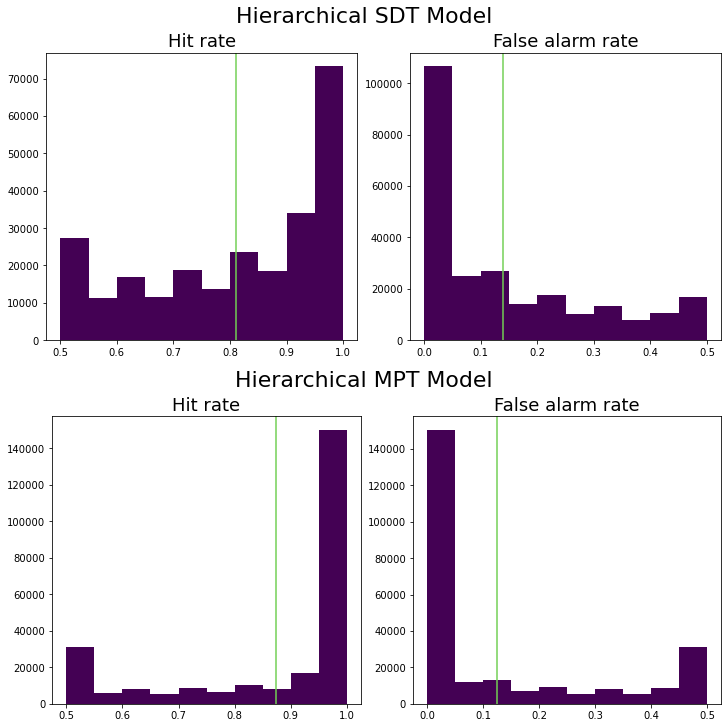

In [8]:
# Plot rates over all data sets

fig = plt.figure(constrained_layout=True, figsize=(10, 10))
subfigs = fig.subfigures(nrows=2, ncols=1)
subfigure_titles = ['Hierarchical SDT Model', 'Hierarchical MPT Model']

hit_rate_list = [sdt_hit_rates.flatten(), mpt_hit_rates.flatten()]
fa_rate_list = [sdt_fa_rates.flatten(), mpt_fa_rates.flatten()]

for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfigure_titles[row], fontsize=22)

    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)

    axs[0].hist(hit_rate_list[row], color='#440154FF')
    axs[0].set_title('Hit rate', fontsize=18)
    axs[0].axvline(np.mean(hit_rate_list[row]), color='#73D055FF')
    axs[1].hist(fa_rate_list[row], color='#440154FF')
    axs[1].set_title('False alarm rate', fontsize=18)
    axs[1].axvline(np.mean(fa_rate_list[row]), color='#73D055FF')

## Hit & false alarm probabilities (participant level)

In [9]:
def get_probs(simulator, model_index, n_data_sets, n_clusters):
    """_summary_

    Parameters
    ----------
    simulator : generative model object
        An initialized hierarchical simulator
    model_index : int
        Index coding the simulations from the targeted model.
    n_data_sets : int
        Number of data sets to simulate.
    n_clusters : int
        Number of higher order clusters that the observations are nested in.

    Returns
    -------
    hit_probs : np.array
        Hit probability per participant for each simulated data set with shape (n_data_sets, n_clusters).
    fa_probs : np.array
        False probability per participant for each simulated data set with shape (n_data_sets, n_clusters).
    """

    hit_probs = np.empty((n_data_sets, n_clusters))
    fa_probs = np.empty((n_data_sets, n_clusters))

    for d in range(n_data_sets):
        hit_probs[d, :], fa_probs[d, :] = simulator.draw_from_prior(model_index=model_index, n_clusters=n_clusters)

    return hit_probs, fa_probs

In [10]:
# Get hit probabilities and false alarm probabilities
prob_simulator = HierarchicalSdtMptSimulator()
sdt_hit_probs, sdt_fa_probs = get_probs(simulator=prob_simulator, model_index=0, n_data_sets=n_data_sets, n_clusters=n_clusters)
mpt_hit_probs, mpt_fa_probs = get_probs(simulator=prob_simulator, model_index=1, n_data_sets=n_data_sets, n_clusters=n_clusters)

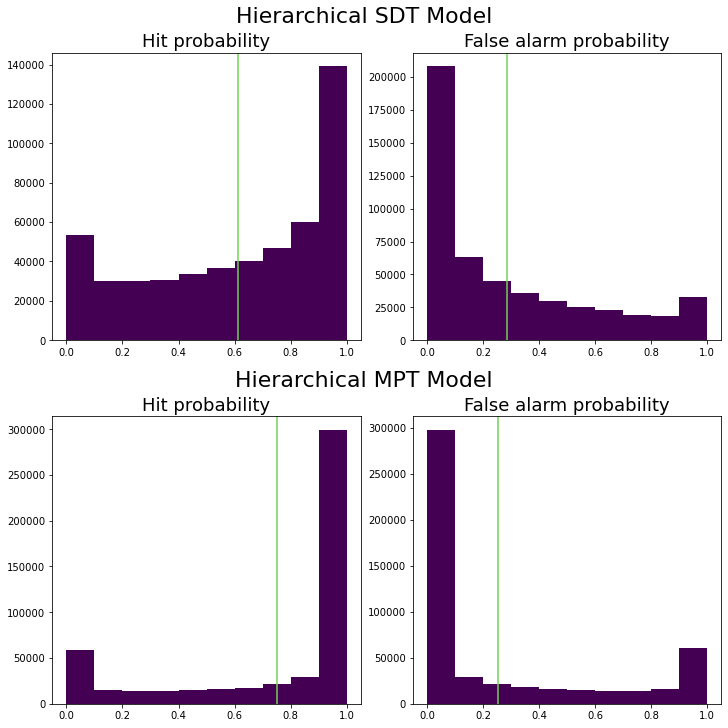

In [11]:
# Plot probabilities over all data sets

fig = plt.figure(constrained_layout=True, figsize=(10, 10))
subfigs = fig.subfigures(nrows=2, ncols=1)
subfigure_titles = ['Hierarchical SDT Model', 'Hierarchical MPT Model']

hit_rate_list = [sdt_hit_probs.flatten(), mpt_hit_probs.flatten()]
fa_rate_list = [sdt_fa_probs.flatten(), mpt_fa_probs.flatten()]

for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfigure_titles[row], fontsize=22)

    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)

    axs[0].hist(hit_rate_list[row], color='#440154FF')
    axs[0].set_title('Hit probability', fontsize=18)
    axs[0].axvline(np.mean(hit_rate_list[row]), color='#73D055FF')
    axs[1].hist(fa_rate_list[row], color='#440154FF')
    axs[1].set_title('False alarm probability', fontsize=18)
    axs[1].axvline(np.mean(fa_rate_list[row]), color='#73D055FF')